# setting up

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import scanpy as sc 

In [2]:
from SingleCellArchetype.main import SCA
from SingleCellArchetype.utils import plot_archetype
from SingleCellArchetype.utils import get_relative_variation

# Load data

In [3]:
%%time
f_anndata_in  = "../../data/v1_multiome/run_sca/multiome_l23_p21_hvg.h5ad"
adata_hvg = sc.read(f_anndata_in)
adata_hvg

CPU times: user 174 ms, sys: 343 ms, total: 517 ms
Wall time: 2.02 s


AnnData object with n_obs × n_vars = 2213 × 4420
    obs: 'Age', 'Doublet', 'Doublet Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet?', 'Study', 'Type_leiden', 'time', 'cond'
    var: 'feature_types'
    layers: 'lognorm', 'norm', 'zlognorm'

In [4]:
genes_hvg = adata_hvg.var.index.values

# Run SingleCellArchetype with different controls

- First, we can infer archetypes using the original data. 
- To assess the **stability** of archetypal inference, we downsample cells (or genes) and repeat the inference.
- To assess the **statistical significance of the archetypal fit**, we **shuffle the data** and compare the shuffled results with data. The effect can be directly visualized, and quantified using t-ratio test. 
- To assess the **significance of the transcriptomic continuum**, we shuffle the data **locally within each cell type (or cluster)**. The effect can be directly visualzed (and later quantified). 

In [5]:
types = [0]*len(adata_hvg)
norm_mat = np.array(adata_hvg.layers['lognorm'])
sca = SCA(norm_mat, types)

In [6]:
ndim = 2
noc = 3
nrepeats = 3
np.random.seed(0)

sca.setup_feature_matrix(method='data')
xp, aa = sca.proj_and_pcha(ndim, noc)
aa_boots = sca.bootstrap_proj_pcha(ndim, noc, nrepeats=nrepeats)

use data


In [7]:
# gshuff
sca.setup_feature_matrix(method='gshuff')
xp_gshuff, aa_gshuff = sca.proj_and_pcha(ndim, noc)
aa_gshuff_boots = sca.bootstrap_proj_pcha(ndim, noc, nrepeats=nrepeats)

use shuffled data


In [8]:
# tshuff 
sca.setup_feature_matrix(method='tshuff')
xp_tshuff, aa_tshuff = sca.proj_and_pcha(ndim, noc)
aa_tshuff_boots = sca.bootstrap_proj_pcha(ndim, noc, nrepeats=nrepeats)

use per-type shuffled data


## plot

In [9]:
types_colorvec = np.char.add('C', sca.types_idx.astype(str))

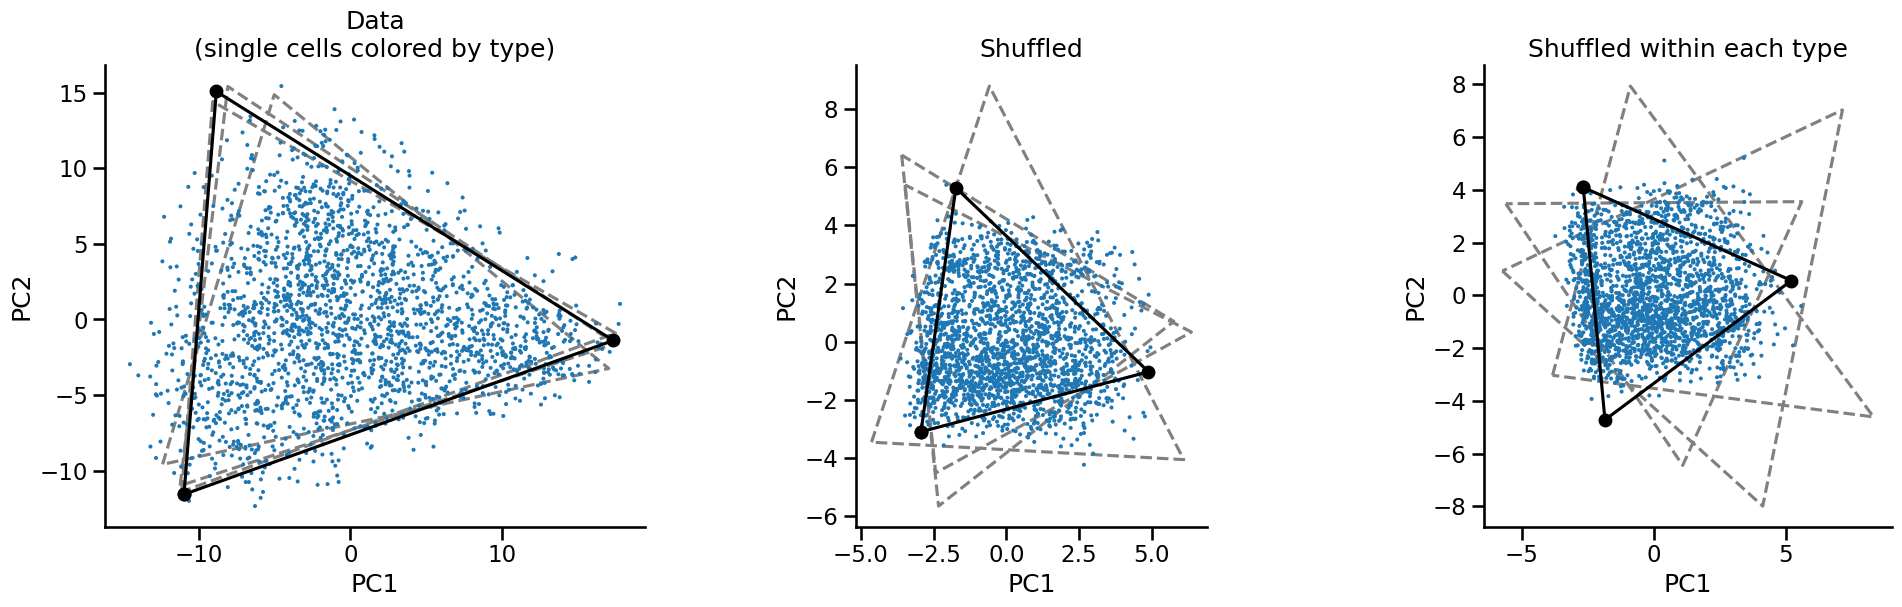

In [10]:
# plot
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
ax.scatter(xp[:,0], xp[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_boots[i], fmt='--', color='gray', zorder=0)
ax.set_title('Data\n(single cells colored by type)')
    
ax = axs[1]
ax.set_title('Shuffled')
ax.scatter(xp_gshuff[:,0], xp_gshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_gshuff, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_gshuff_boots[i], fmt='--', color='gray', zorder=0)

ax = axs[2]
ax.set_title('Shuffled within each type')
ax.scatter(xp_tshuff[:,0], xp_tshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_tshuff, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_tshuff_boots[i], fmt='--', color='gray', zorder=0)

for i in range(3):
    ax = axs[i]
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_aspect('equal')
    sns.despine(ax=ax)
    ax.grid(False)
    
plt.show()

## quantify t-ratio 
- for 2-dimensional data only

In [11]:
t_ratio, t_ratio_shuffs, pval = sca.t_ratio_test_2d(ndim, noc, nrepeats=20)
print(f'p-value: {pval}')

use data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
p-value: 0.05


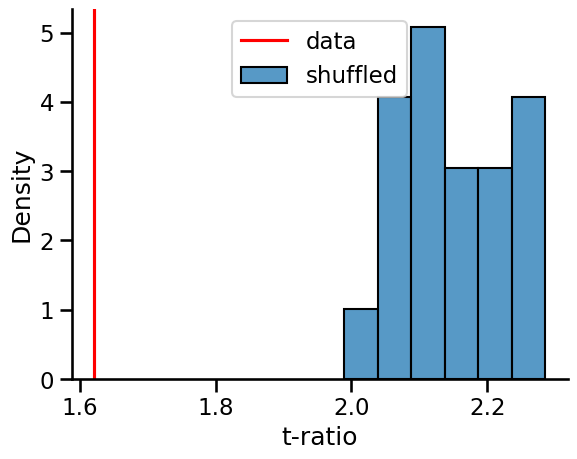

In [12]:
fig, ax = plt.subplots()
ax.axvline(t_ratio, color='r', label='data')
sns.histplot(t_ratio_shuffs, ax=ax, stat='density', label='shuffled')
ax.set_xlabel('t-ratio')
ax.legend()
sns.despine(ax=ax)
plt.show()

## quantify bootstrap stability

In [13]:
var_data   = get_relative_variation(aa_boots)
var_gshuff = get_relative_variation(aa_gshuff_boots)

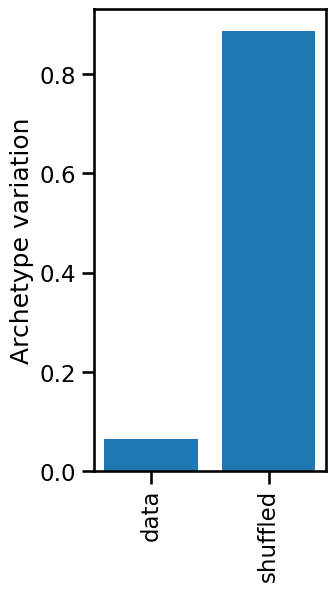

In [14]:
fig, ax = plt.subplots(figsize=(3,6))
ax.bar(np.arange(2), [var_data, var_gshuff])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['data', 'shuffled'], rotation=90)
ax.set_ylabel('Archetype variation')
plt.show()